In [1]:
import pandas as pd
import numpy as np
from factor_analyzer import FactorAnalyzer
# import nilearn"

In [2]:
data = pd.read_csv('noraml_results.csv',low_memory=False)
data = data.set_index(['SubjectID'])
y = pd.read_csv('train_labels_MGMT.csv')
y = y.set_index(['BraTS21ID'])

# ids = data['SubjectID']
y.head()

,MGMT_value
BraTS21ID,
0,1
2,1
3,0
5,1
6,1


In [3]:
# data = data.drop(['SubjectID'],axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1208 entries, 0 to 1666
Columns: 545 entries, FLAIR_ED_Intensity_CoefficientOfVariation to T2_ED_LBP_Radius-1_Bins-20_LBP
dtypes: float64(334), int64(135), object(76)
memory usage: 5.0+ MB


In [4]:

# np.sum(data_numeric['FLAIR_ED_Intensity_CoefficientOfVariation'].astype(float).isnull())
data_numeric = data.apply(pd.to_numeric,errors='coerce')
data_na = data_numeric[data_numeric.isna().any(axis=1)]

# data_na.drop([293,743,904],axis=0)
data_na





,FLAIR_ED_Intensity_CoefficientOfVariation,FLAIR_ED_Intensity_Energy,FLAIR_ED_Intensity_InterQuartileRange,FLAIR_ED_Intensity_Kurtosis,FLAIR_ED_Intensity_Maximum,FLAIR_ED_Intensity_Mean,FLAIR_ED_Intensity_MeanAbsoluteDeviation,FLAIR_ED_Intensity_Median,FLAIR_ED_Intensity_MedianAbsoluteDeviation,FLAIR_ED_Intensity_Minimum,...,T2_ED_GLSZM_Bins-20_Radius-1_ZoneSizeMean,T2_ED_GLSZM_Bins-20_Radius-1_ZoneSizeNonUniformity,T2_ED_GLSZM_Bins-20_Radius-1_ZoneSizeNoneUniformityNormalized,T2_ED_GLSZM_Bins-20_Radius-1_ZoneSizeVariance,T2_ED_NGTDM_Busyness,T2_ED_NGTDM_Coarsness,T2_ED_NGTDM_Complexity,T2_ED_NGTDM_Contrast,T2_ED_NGTDM_Strength,T2_ED_LBP_Radius-1_Bins-20_LBP
SubjectID,,,,,,,,,,,,,,,,,,,,,
14,0.144956,4.546696e+04,30.747772,0.250000,165.364304,149.990418,0.000000e+00,149.990418,0.000000,134.616531,...,1.000000,2.000000,1.000000,0.000000,0.552632,0.095238,199.500000,947.625000,34.380952,30.064860
140,0.030319,1.500581e+06,6.000000,2.807781,170.538467,158.073077,-5.684342e-15,157.730774,0.342303,147.692307,...,1.132075,42.169811,0.795657,0.152367,0.253918,0.024048,1523.005645,1.244576,3.517641,863.496703
258,0.163524,6.730304e+04,18.422050,1.270947,142.205322,114.798476,-5.684342e-15,109.239540,5.558936,93.403038,...,1.250000,2.500000,0.625000,0.187500,0.500000,0.063291,319.466667,67.466667,12.007273,70.456887
338,0.014886,1.571243e+05,4.467148,1.066010,164.540146,161.810219,0.000000e+00,161.934311,-0.124092,158.583939,...,1.200000,3.400000,0.680000,0.160000,0.380952,0.093750,317.888889,29.948148,14.346154,90.171584
425,NaN,2.377845e+03,0.000000,NaN,48.763157,48.763157,0.000000e+00,48.763157,0.000000,48.763157,...,1.000000,1.000000,1.000000,0.000000,0.000000,0.050000,0.000000,0.000000,0.000000,15.032430
444,0.087228,5.655807e+04,7.083336,1.831951,91.901711,79.006412,3.157968e-15,75.918808,3.087604,71.378204,...,1.000000,9.000000,1.000000,0.000000,0.379397,0.059603,456.566667,28.498765,13.892720,135.282465
1180,NaN,1.272891e+04,0.000000,NaN,112.822472,112.822472,0.000000e+00,112.822472,0.000000,112.822472,...,1.000000,1.000000,1.000000,0.000000,0.000000,0.050000,0.000000,0.000000,0.000000,15.032430
1344,NaN,3.459157e+04,0.000000,NaN,185.988098,185.988098,0.000000e+00,185.988098,0.000000,185.988098,...,1.000000,1.000000,1.000000,0.000000,0.000000,0.050000,0.000000,0.000000,0.000000,15.032430
1568,0.106352,2.146930e+05,15.738022,2.803975,199.955627,163.014196,0.000000e+00,160.067993,2.946203,145.281250,...,1.000000,8.000000,1.000000,0.000000,0.309524,0.102564,321.500000,17.375000,15.200000,120.201633


In [5]:
data_clean = data_numeric.dropna()
data_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1199 entries, 0 to 1666
Columns: 545 entries, FLAIR_ED_Intensity_CoefficientOfVariation to T2_ED_LBP_Radius-1_Bins-20_LBP
dtypes: float64(410), int64(135)
memory usage: 5.0 MB


In [6]:
indices = np.intersect1d(data_clean.index.values , y.index.values)
labeled_data = data_clean.loc[indices]
y = y.loc[indices]
labeled_data.head()

,FLAIR_ED_Intensity_CoefficientOfVariation,FLAIR_ED_Intensity_Energy,FLAIR_ED_Intensity_InterQuartileRange,FLAIR_ED_Intensity_Kurtosis,FLAIR_ED_Intensity_Maximum,FLAIR_ED_Intensity_Mean,FLAIR_ED_Intensity_MeanAbsoluteDeviation,FLAIR_ED_Intensity_Median,FLAIR_ED_Intensity_MedianAbsoluteDeviation,FLAIR_ED_Intensity_Minimum,...,T2_ED_GLSZM_Bins-20_Radius-1_ZoneSizeMean,T2_ED_GLSZM_Bins-20_Radius-1_ZoneSizeNonUniformity,T2_ED_GLSZM_Bins-20_Radius-1_ZoneSizeNoneUniformityNormalized,T2_ED_GLSZM_Bins-20_Radius-1_ZoneSizeVariance,T2_ED_NGTDM_Busyness,T2_ED_NGTDM_Coarsness,T2_ED_NGTDM_Complexity,T2_ED_NGTDM_Contrast,T2_ED_NGTDM_Strength,T2_ED_LBP_Radius-1_Bins-20_LBP
SubjectID,,,,,,,,,,,,,,,,,,,,,
0,0.208407,3.254983e+08,52.321060,2.431036,255.000000,163.021809,1.919267e-12,161.699890,1.321919,24.422291,...,11.042333,327.728128,0.308305,4157.763965,54.420395,0.000097,1711.948149,0.575090,0.014729,107274.15920
2,0.244847,3.808142e+08,78.997269,1.795272,255.000000,178.721718,1.858122e-12,186.449478,-7.727760,56.710884,...,14.703268,230.304575,0.301052,7391.353780,44.516416,0.000114,1825.575997,1.093795,0.016610,93992.93477
3,0.181312,5.510956e+08,45.213333,2.908945,254.999985,176.055364,-1.379775e-13,174.889374,1.165990,32.076485,...,18.158228,283.881857,0.299453,24304.150070,78.682617,0.000044,2274.138544,0.444564,0.008198,147720.97780
5,0.072773,6.317700e+08,11.431259,7.245500,203.352692,161.191300,-5.097529e-13,162.585754,-1.394454,66.797195,...,19.105055,452.672986,0.357562,90220.473170,171.964074,0.000011,4423.374274,0.499853,0.007507,197818.19730
6,0.067105,1.039722e+09,18.007401,4.290105,248.451858,201.447461,1.025481e-12,201.229629,0.217832,66.992592,...,33.254237,214.812255,0.280068,126187.253500,168.983159,0.000015,2878.917449,0.299087,0.004468,211392.14770


In [7]:
from sklearn.decomposition import PCA
pca = PCA(n_components=100)
X_pca = pca.fit_transform(data_clean)
X_pca.shape

(1199, 100)

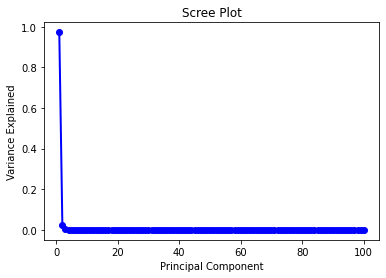

In [8]:
import matplotlib.pyplot as plt
PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

In [9]:
from sklearn.metrics import mean_squared_error
X_pred = pca.inverse_transform(X_pca)
mean_squared_error(data_clean,X_pred)

994.8600819324075

In [10]:
data_clean.describe()

,FLAIR_ED_Intensity_CoefficientOfVariation,FLAIR_ED_Intensity_Energy,FLAIR_ED_Intensity_InterQuartileRange,FLAIR_ED_Intensity_Kurtosis,FLAIR_ED_Intensity_Maximum,FLAIR_ED_Intensity_Mean,FLAIR_ED_Intensity_MeanAbsoluteDeviation,FLAIR_ED_Intensity_Median,FLAIR_ED_Intensity_MedianAbsoluteDeviation,FLAIR_ED_Intensity_Minimum,...,T2_ED_GLSZM_Bins-20_Radius-1_ZoneSizeMean,T2_ED_GLSZM_Bins-20_Radius-1_ZoneSizeNonUniformity,T2_ED_GLSZM_Bins-20_Radius-1_ZoneSizeNoneUniformityNormalized,T2_ED_GLSZM_Bins-20_Radius-1_ZoneSizeVariance,T2_ED_NGTDM_Busyness,T2_ED_NGTDM_Coarsness,T2_ED_NGTDM_Complexity,T2_ED_NGTDM_Contrast,T2_ED_NGTDM_Strength,T2_ED_LBP_Radius-1_Bins-20_LBP
count,1199.000000,1.199000e+03,1199.000000,1199.000000,1199.000000,1199.000000,1.199000e+03,1199.000000,1199.000000,1199.000000,...,1199.000000,1199.000000,1199.000000,1.199000e+03,1199.000000,1199.000000,1199.000000,1199.000000,1199.000000,1.199000e+03
mean,0.177393,2.788463e+08,28.227742,4.106583,203.710118,130.633555,1.086488e-14,130.736884,-0.103329,53.261240,...,20.315380,159.341054,0.265491,7.458329e+04,75.264390,0.001429,2105.862708,0.776669,0.227368,1.301169e+05
std,0.106284,4.624571e+08,17.023168,2.823798,38.596151,34.396343,1.684440e-12,36.125748,4.532596,40.109458,...,22.100887,144.147530,0.071981,3.130635e+05,112.526819,0.005588,776.021939,0.950911,0.828718,1.729391e+05
min,0.023032,2.774825e+05,4.767082,1.382338,46.064514,24.786431,-1.581604e-11,16.642105,-34.007919,0.000000,...,1.130435,4.444444,0.127105,1.134216e-01,0.178870,0.000003,284.604279,0.062522,0.000695,1.556113e+02
25%,0.108103,3.765783e+07,16.948475,2.800031,176.987129,107.583285,-2.199055e-13,106.656532,-1.652268,18.905645,...,7.867821,57.553633,0.220451,6.905632e+02,11.163657,0.000042,1572.574407,0.440125,0.008473,2.337438e+04
50%,0.156493,1.219505e+08,24.118378,3.446138,208.298538,127.133757,-2.561957e-15,127.062866,0.035359,48.036270,...,14.631893,119.649484,0.252169,5.721402e+03,37.037973,0.000120,1910.085217,0.637600,0.021977,7.317508e+04
75%,0.218871,3.398300e+08,34.073505,4.553877,235.774460,154.697804,1.935651e-13,156.366913,1.820806,80.806946,...,24.983548,211.650124,0.291940,3.371772e+04,92.430472,0.000429,2429.414300,0.916014,0.076311,1.708382e+05
max,1.054095,4.685167e+09,163.679184,57.406124,272.704315,229.664194,2.599775e-11,228.763855,32.019490,204.739380,...,355.101124,1532.664084,0.773157,5.783924e+06,1052.830628,0.072072,5478.541734,24.580977,10.253666,1.509632e+06


In [11]:
from sklearn.decomposition import KernelPCA
kPca = KernelPCA(n_components=10,kernel='poly')
X_kpca = kPca.fit_transform(data_clean)
X_kpca.shape

(1199, 10)

In [12]:
labeled_pca = pca.transform(labeled_data)

In [13]:
from sklearn.decomposition import FactorAnalysis
fa = FactorAnalysis(n_components=10)
X_fa = fa.fit_transform(data_clean)
X_fa.shape

(1199, 10)

In [14]:
labeled_fa = fa.transform(labeled_data)


In [16]:
labeled_combined = np.concatenate([labeled_fa,labeled_pca],axis=1)
labeled_combined = pd.DataFrame(labeled_combined)
labeled_combined.describe()

,0,1,2,3,4,5,6,7,8,9,...,100,101,102,103,104,105,106,107,108,109
count,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,...,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000
mean,-0.139016,-0.006335,-0.112030,-0.055891,-0.051122,-0.014636,-0.002254,-0.024348,-0.034576,-0.002252,...,-20.364678,12.564256,-5.218441,13.130508,12.410582,-14.316227,-10.991860,-8.767581,-10.876600,-1.047690
std,0.722216,0.798788,0.855184,0.944046,0.992652,0.523050,0.417458,0.599996,0.719143,1.036529,...,257.445584,228.770888,200.017260,254.570178,231.793362,223.645390,200.666479,189.345934,191.537999,204.738299
min,-0.714896,-2.831533,-9.825780,-5.481022,-10.886261,-4.132887,-2.899020,-6.132873,-3.955910,-1.105053,...,-1149.911217,-1446.957637,-776.826820,-2224.984151,-1135.114148,-805.501281,-1170.547921,-1061.932346,-983.182404,-1388.455660
25%,-0.619967,-0.184673,-0.228979,-0.191572,-0.181996,-0.171317,-0.116778,-0.154945,-0.069786,-0.470407,...,-151.243897,-84.608030,-89.430388,-92.107259,-106.573538,-135.179107,-88.960805,-82.511612,-91.366664,-73.956096
50%,-0.373344,0.007638,-0.033266,-0.035443,0.084561,0.122996,0.098741,-0.007736,0.019053,-0.274051,...,-15.764341,3.633753,-0.977103,10.748847,21.511119,-18.384319,-1.330616,-4.527351,-6.867797,-1.570935
75%,0.097288,0.064354,0.035288,0.106316,0.180315,0.339436,0.170832,0.036717,0.042904,0.046087,...,109.960741,100.699956,88.975101,97.121306,135.747088,98.767068,77.385958,81.958227,70.298091,69.914339
max,7.515531,12.711192,6.980558,9.843296,13.299596,2.389520,2.385843,4.575457,14.092927,10.612144,...,1872.951759,1795.170106,1198.879919,1554.033163,1037.424503,1314.063795,912.855704,812.849289,818.874884,1162.455850


In [17]:
temp = np.ravel(y)
temp.shape

(555,)

In [18]:
from sklearn.feature_selection import r_regression
pear = r_regression(labeled_pca,temp)
pear = pd.DataFrame(pear)
pear_clean = pear[~pear.isin([np.nan, np.inf, -np.inf]).any(1)]

In [19]:
pear_clean.describe()

,0
count,100.000000
mean,-0.000288
std,0.043763
min,-0.097530
25%,-0.029685
50%,0.004053
75%,0.032887
max,0.089093


In [66]:
from sklearn.ensemble import RandomForestClassifier
rnd_clf = RandomForestClassifier(n_estimators=100)
rnd_clf.fit(labeled_combined,temp)

RandomForestClassifier()

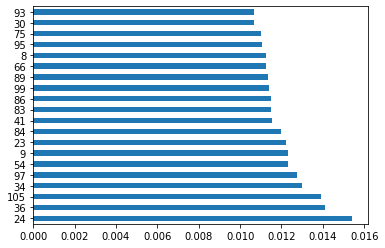

In [67]:
feat_importances = pd.Series(rnd_clf.feature_importances_, index=np.arange(labeled_combined.shape[1]))
feat_importances.nlargest(20).plot(kind='barh')
plt.show()

In [31]:
from sklearn.feature_selection import RFE
selector_rfe = RFE(estimator=rnd_clf,n_features_to_select=20,step=1).fit(labeled_combined,temp)

In [64]:
ranking_rfe = np.argpartition(selector_rfe.ranking_,30)[:30]
ranking_rfe

array([ 23,  82,  58, 108, 105,  61,  70,  74,   8,  37,  36,  11,  75,
        97,  30,  93,  54,  91,  84,  24,  55,  41,  44, 101,  89,  78,
        35,  31,   9, 103])

In [33]:
selector_rfe.ranking_

array([89, 87, 23, 86, 76, 83, 91, 73,  1, 10, 77,  1, 60, 66, 81, 58, 45,
       52, 41, 39, 61, 79, 14,  1,  1, 75, 51, 82, 62, 90,  1,  9, 32, 48,
       28,  8,  1,  1, 12, 74, 50,  3, 69, 36,  4, 72, 85, 43, 27, 25, 88,
       84, 67, 80,  1,  2, 57, 22,  1, 59, 18,  1, 20, 19, 71, 70, 26, 64,
       24, 63,  1, 78, 35, 31,  1,  1, 68, 37,  5, 56, 55, 44,  1, 21,  1,
       15, 34, 46, 47,  6, 29,  1, 17,  1, 53, 40, 16,  1, 33, 30, 42,  7,
       54, 11, 13,  1, 65, 49,  1, 38])

In [34]:
from sklearn.feature_selection import RFECV

selector_rfecv = RFECV(rnd_clf,n_jobs=-1).fit(labeled_combined,temp)

In [35]:
selector_rfecv.ranking_

array([109,  98,  17,  83,  85,  95,  67, 104,  53,  29,  87,  48, 107,
        62,  89,  84,  80,  44, 101,  37, 102, 105,  79,   6,   3, 103,
        82,  92, 100,  90,   1,  39,  43,  72,  24,  15,   7,  21,  64,
         8,  54,  93,  99,  57,  49, 108,  86,  76,  40,  45,  66,  88,
        75, 106,  19,  12,  97,  69,  25,  58,  50,  61,  20,   2,  96,
        55,  81,  78,  41,  68,  13,  74,  94,  91,  35,   9,  56,  63,
        16,  32,  77,  70,  38,  27,  11,  60,  65,  42,  34,  47,  30,
        14,  33,  28,  71,  22,  26,   5,  36,  18,  52,  51,  73,  46,
        31,   1,  59,  23,  10,   4])

In [63]:
ranking_rfecv = np.argpartition(selector_rfecv.ranking_,30)[:30]
ranking_rfecv

array([ 23, 109,   2, 108, 105,  99,  97,  91,  84,  78,  75,  70,  63,
        55,  39,  36,  35,  30,  24,  54,  95,  62, 107,  37,  34,  58,
        96,  83,  93,   9])

In [59]:
from sklearn.feature_selection import SequentialFeatureSelector
sfs = SequentialFeatureSelector(rnd_clf,n_features_to_select=30,n_jobs=-1)
sfs.fit(labeled_combined,temp)

SequentialFeatureSelector(estimator=RandomForestClassifier(),
                          n_features_to_select=30, n_jobs=-1)

In [61]:
ranking_sfs = sfs.get_support(indices=True)
ranking_sfs

array([  1,   6,   7,  10,  12,  13,  17,  21,  22,  30,  31,  35,  38,
        40,  42,  48,  49,  63,  67,  74,  77,  81,  92,  93,  94,  98,
       101, 107, 108, 109])

In [41]:
from sklearn.feature_selection import f_classif
anova = f_classif(labeled_combined,temp)

In [56]:
ranking_anova= np.argpartition(anova[0],-30)[-30:]
ranking_anova

array([ 27, 103,  10,  23,  84,  93,  94,  57,  89,   0,  90,  78,  75,
        70,  58,  45,  42,  39,  36,  35,  24,  13,  12,  11,   4, 105,
         3,   2, 108, 109])

In [49]:
from sklearn.feature_selection import mutual_info_classif
selector_mutual = mutual_info_classif(labeled_combined,temp)

In [72]:
ranking_mut = np.argpartition(selector_mutual,-30)[-30:]
ranking_mut

array([  8,  19,  37,  79,  71,  26,  68,  11,  66,  23,  61,  36,   3,
        86, 102,  91,  16, 105,  30,  64,  43,  82,  44,  95,  80,  77,
        76, 107, 108,  74])

In [70]:
intersect = ranking_rfe
rankings = [ranking_rfe,ranking_rfecv,ranking_sfs,ranking_anova,ranking_mut]
for rank in rankings:
    intersect = np.intersect1d(rank,intersect)

In [71]:
intersect

array([108])